In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.express as px

# statistics
import statsmodels.api as sm

In [2]:
wdi_data = (
    "https://raw.githubusercontent.com/nickeubank/"
    "practicaldatascience/master/Example_Data/wdi_plotting.csv"
)
world = pd.read_csv(wdi_data)

names = world.columns[3:].to_list()

names.append("GDP per capita (constant 2015 US$)")

countries = world["Country Code"].unique()

In [3]:
wdi = pd.read_parquet("data/wdi.parquet")
wdi2 = wdi[wdi["Indicator Name"].isin(names) & wdi["Country Code"].isin(countries)].copy()

indic_name = wdi2["Indicator Name"].unique()

wdi2.columns = wdi2.columns.str.replace(" ", "_")
wdi2.rename(str.lower, axis=1, inplace=True)

dic = dict(zip(indic_name, ["CO2", "GDP", "life_exp", "literacy", "mortality", "child_mortality", "polution", "pop"]))
wdi2 = wdi2.replace({"indicator_name": dic})

years = wdi2.loc[:, '1960':'2021'].columns

wdi2_long1 = wdi2.melt(
    id_vars=wdi2.columns[:4], 
    value_vars=years, 
    value_name="values",
    var_name="year"
)

wdi2_long1 = wdi2_long1.drop(columns="indicator_code")

wdi2_long2 = wdi2_long1.pivot(
    index=["country_name",	"country_code", "year"], columns="indicator_name", 
    values="values"
)

wdi2_long2.columns.name = ""
wdi2_long2 = wdi2_long2.reset_index()
wdi2_long2["year"] = wdi2_long2.year.astype(int)



In [4]:
indicators = wdi["Indicator Name"].unique()
indicators = pd.Series(indicators)

indicators[indicators.str.contains("region")]

751    Merchandise exports to low- and middle-income ...
752    Merchandise exports to low- and middle-income ...
764    Merchandise imports from low- and middle-incom...
765    Merchandise imports from low- and middle-incom...
dtype: object

In [5]:
wdi_country = pd.read_csv("data/WDICountry.csv")

wdi2_long2 = wdi2_long2.merge(wdi_country[["Country Code", "Short Name", "Region"]], left_on="country_code", right_on="Country Code", how="left")

wdi2_long2.drop(columns=["Country Code"], inplace=True)

wdi2_long2.rename(columns={"Region": "region", "Short Name": "country"}, inplace=True)

In [6]:
wdi2_long2.region.value_counts(dropna=False)

Europe & Central Asia         3596
Sub-Saharan Africa            2976
Latin America & Caribbean     2604
East Asia & Pacific           2294
Middle East & North Africa    1302
South Asia                     496
North America                  186
Name: region, dtype: int64

In [7]:
wdi_2020 = wdi2_long2.query('year == 2020')

wdi_2020 = wdi_2020.assign(
    log_gdp = lambda x: np.log(x.GDP),
    log_child_mortality = lambda x: np.log(x.child_mortality),
)

In [8]:
big_countries = wdi_2020.nlargest(10, "pop")["country"]
idx = wdi_2020["country"].isin(big_countries)
wdi_2020_big = wdi_2020[idx]

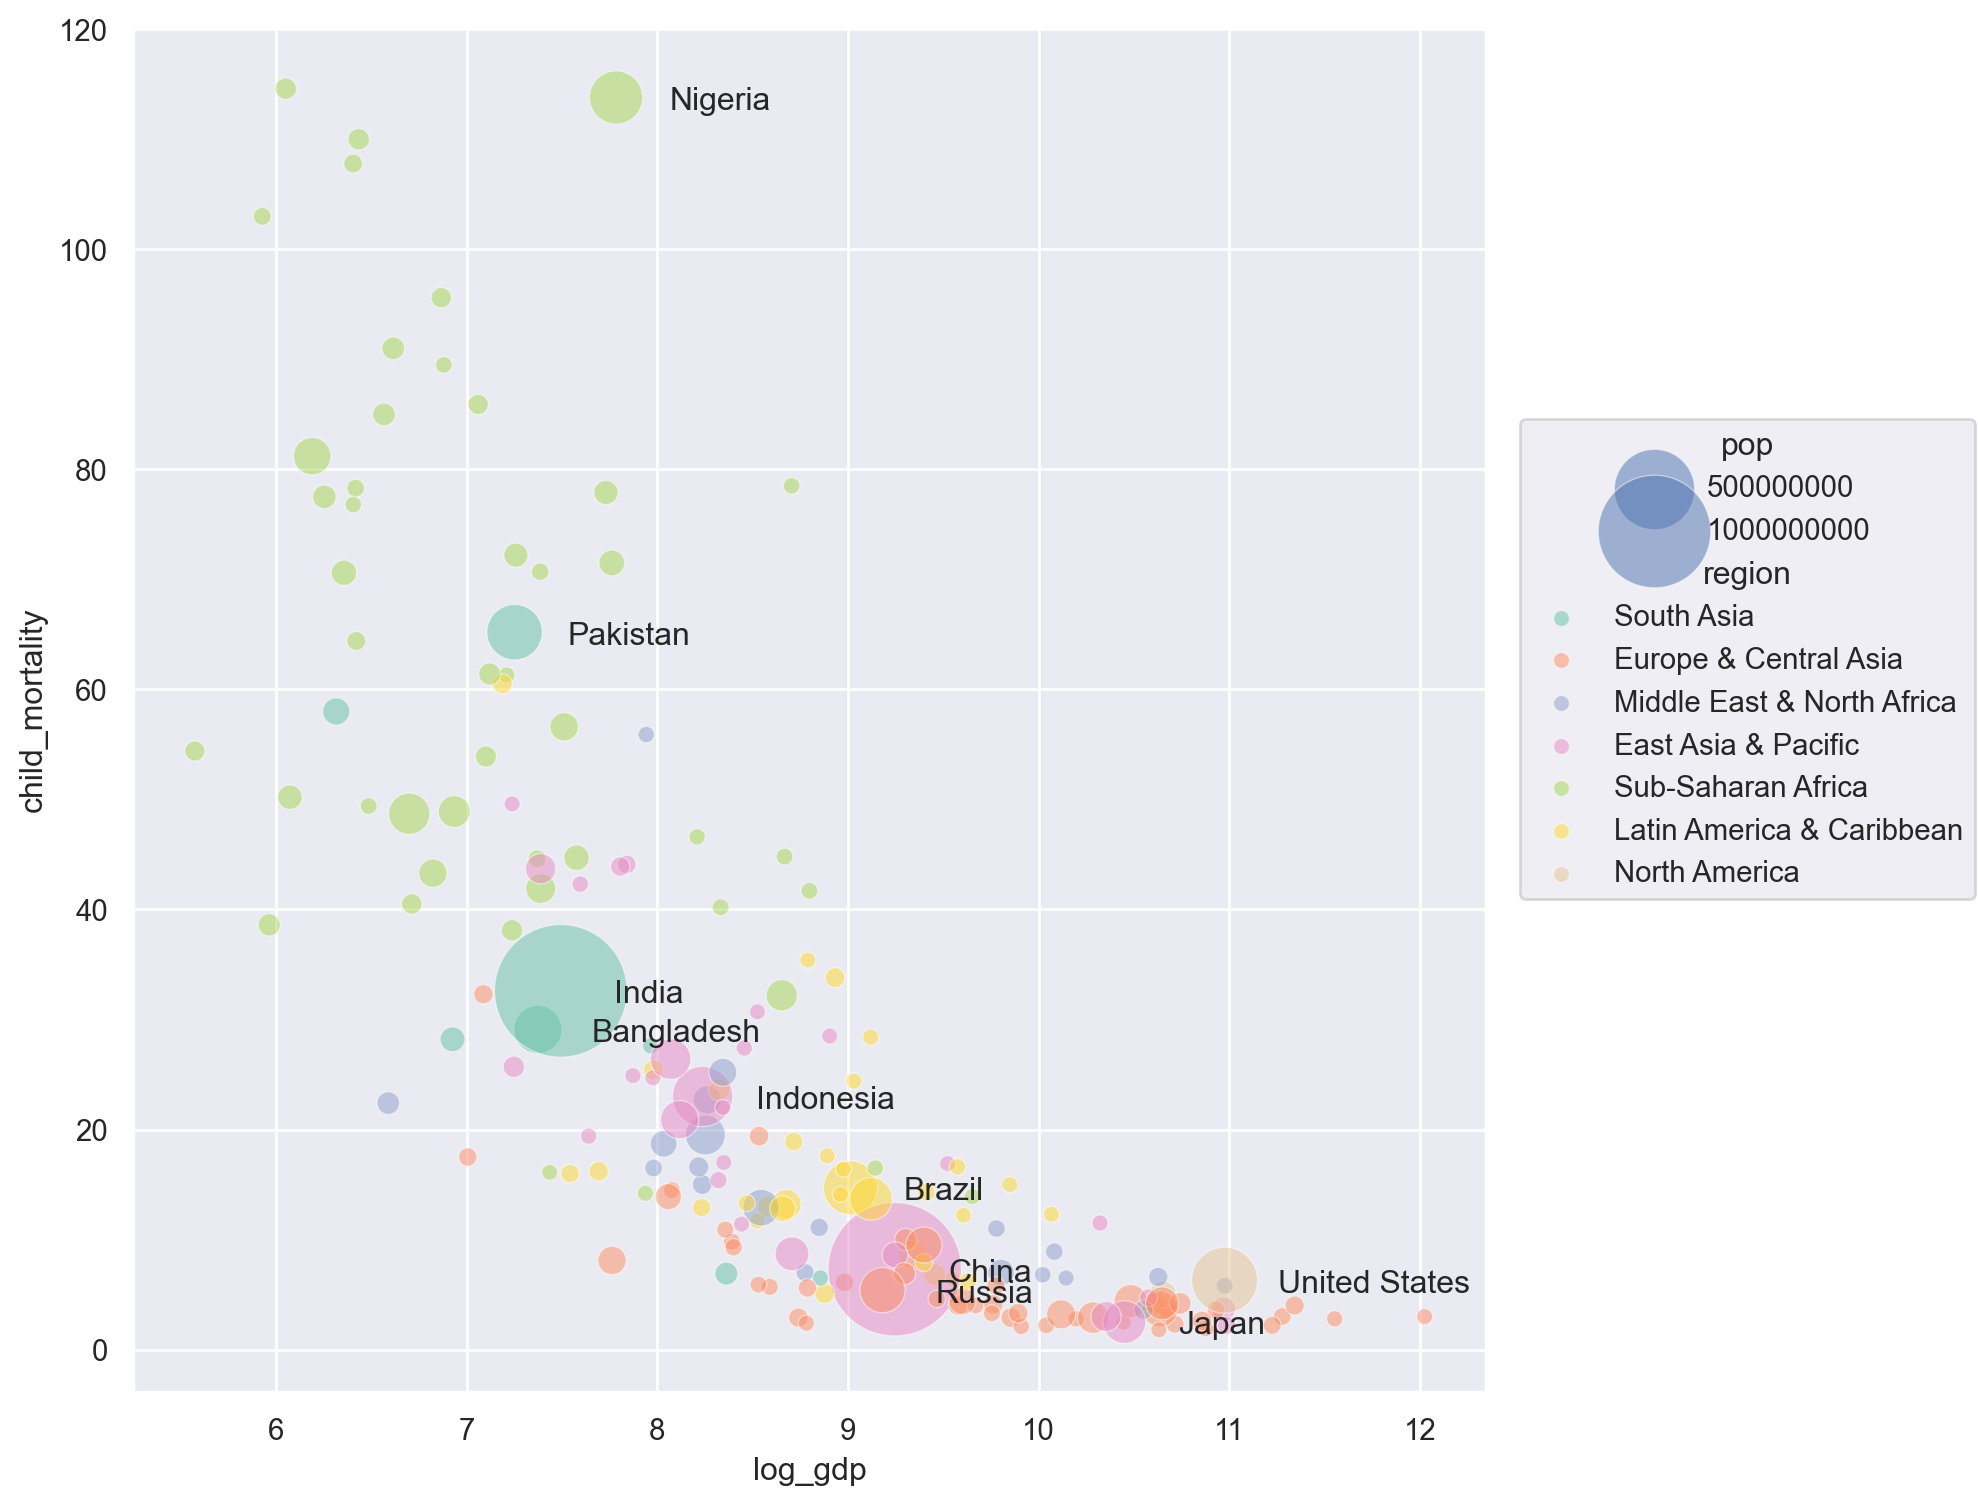

In [9]:
(
    so.Plot(wdi_2020, x="log_gdp", y="child_mortality")
    .add(so.Dot(edgecolor="white", alpha=.5), pointsize="pop", color="region")
    .scale(pointsize=(6, 50), color="Set2")
    .layout(size=(8, 8))
    .add(so.Text(halign="left", offset=20), 
         x=wdi_2020_big.log_gdp, 
         y=wdi_2020_big.child_mortality, 
         text=wdi_2020_big.country)
)

In [10]:
wdi_2020_2 = wdi_2020.dropna(subset=["log_gdp", "log_child_mortality", "pop"])

import plotly.express as px
import plotly.io as pio
#pio.renderers.default = "plotly_mimetype+notebook"

fig = px.scatter(wdi_2020_2, 
                 x="log_gdp", y="child_mortality", 
                 size="pop", size_max=40,
                 hover_name="country_name")
fig.show()

In [11]:
wdi_2020.head()

,country_name,country_code,year,CO2,GDP,child_mortality,life_exp,literacy,mortality,polution,pop,country,region,log_gdp,log_child_mortality
60,Afghanistan,AFG,2020,NaN,553.036479,58.0,62.575,NaN,NaN,NaN,38972230.0,Afghanistan,South Asia,6.315424,4.060443
122,Albania,ALB,2020,NaN,4410.455165,9.8,76.989,NaN,NaN,NaN,2837849.0,Albania,Europe & Central Asia,8.391733,2.282382
184,Algeria,DZA,2020,NaN,3873.510015,22.7,74.453,NaN,NaN,NaN,43451666.0,Algeria,Middle East & North Africa,8.261916,3.122365
246,American Samoa,ASM,2020,NaN,14303.627033,NaN,NaN,NaN,NaN,NaN,46189.0,American Samoa,East Asia & Pacific,9.568268,NaN
308,Andorra,AND,2020,NaN,34394.277553,2.5,NaN,NaN,NaN,NaN,77700.0,Andorra,Europe & Central Asia,10.445645,0.916291


In [20]:
wdi_2020.to_csv("data/wdi_2020.csv", index=False)